# Exercise 9
Try using a denoising autoencoder to pretrain an image classifier. You can use MNIST (the simplest option), or a more complex image dataset such as CIFAR10 if you want a bigger challenge. Regardless of the dataset you’re using, follow these steps:Split the dataset into a training set and a test set.

* Train a deep denoising autoencoder on the full training set. Check that the images are fairly well reconstructed.
* Visualize the images that most activate each neuron in the coding layer. Build a classification DNN, reusing the lower layers of the autoencoder.
* Train it using only 500 images from the training set. Does it perform better with or without pretraining?

## Global settings

In [31]:
max_epochs = 1

## Load Dependencies

In [32]:
from collections import Counter
from functools import partial
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [33]:
# load custom functions
%run ./exercises_ch17.py

## Get CIFAR 10 data

In [34]:
(X_train, y_train), (X_test, y_test) = get_cifar10_data()

## Train CNN Autoencoder

### Define architecture

In [35]:
X_train.shape

(50000, 32, 32, 3)

In [57]:
cnn_layer = partial(keras.layers.Conv2D, kernel_size=3, padding='same', activation='selu')

In [58]:
encoder = keras.models.Sequential([
    keras.layers.Input(shape=X_train.shape[1:]),
    cnn_layer(filters=32),
    keras.layers.BatchNormalization(),
    cnn_layer(filters=32),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    cnn_layer(filters=64),
    keras.layers.BatchNormalization(),
    cnn_layer(filters=64),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    cnn_layer(filters=128),
    keras.layers.BatchNormalization(),
    cnn_layer(filters=128),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
])

In [59]:
encoder.output_shape

(None, 4, 4, 128)

In [60]:
cnn_t_layer = partial(keras.layers.Conv2DTranspose, kernel_size=3, padding='same', activation='selu', strides=2)

In [61]:
decoder = keras.models.Sequential([
    keras.layers.Input(shape=encoder.output_shape[1:]),
    cnn_layer(filters=64),
    cnn_t_layer(filters=64),
    cnn_layer(filters=32),
    cnn_t_layer(filters=32),
    cnn_t_layer(filters=3)
])

In [62]:
decoder.output_shape

(None, 32, 32, 3)

In [63]:
4*4*128

2048

In [64]:
autoencoder = keras.models.Sequential([encoder, decoder])

### Train model

In [65]:
optimizer = keras.optimizers.Nadam()
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mse'])

In [66]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)
model_cb = keras.callbacks.ModelCheckpoint(filepath='cnn_autoencoder_cifar10.sav', save_best_only=True)
callbacks = [early_stopping_cb, model_cb]

In [ ]:
history = autoencoder.fit(X_train, X_train, batch_size=128, epochs=max_epochs, validation_data=(X_test, X_test), callbacks=callbacks)

Train on 50000 samples, validate on 10000 samples
17792/50000 [=========>....................] - ETA: 3:22 - loss: 1.2513 - mse: 0.1467

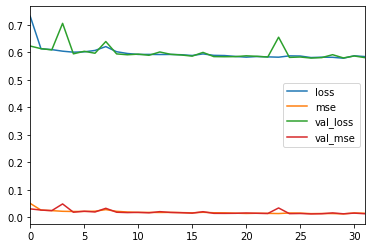

In [350]:
pd.DataFrame(history.history).plot()
plt.show()

### Plot some examples

In [351]:
np.random.seed(142)
plot_results = partial(plot_image_and_reconstruction, X=X_train, model=autoencoder)

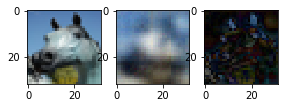

In [352]:
plot_results()

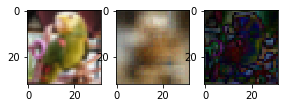

In [353]:
plot_results()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


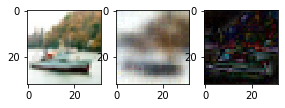

In [354]:
plot_results()

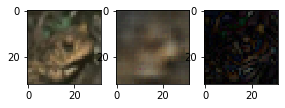

In [355]:
plot_results()

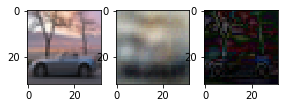

In [356]:
plot_results()

In [174]:
idx = 1

In [160]:
image = X_train[idx]
[reconstruction] = autoencoder.predict(image[np.newaxis,:])
difference = image - reconstruction

<Figure size 324x216 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


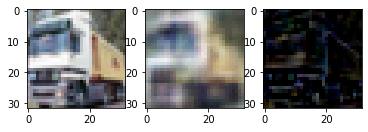

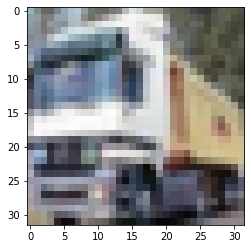

In [156]:
plt


In [101]:
# get smaller training dataset to compare semi-supervised learning
n = 512
X_train_small, y_train_small = get_stratified_sample(n, X_train, y_train)

In [102]:
Counter(y_train.squeeze())

Counter({6: 5000,
         9: 5000,
         4: 5000,
         1: 5000,
         2: 5000,
         7: 5000,
         8: 5000,
         3: 5000,
         5: 5000,
         0: 5000})

In [103]:
Counter(y_train_small.squeeze())

Counter({5: 51, 6: 51, 4: 51, 3: 51, 8: 52, 0: 51, 7: 51, 1: 52, 2: 51, 9: 51})

## Train CNN on reduced data

In [105]:
model = keras.models.Sequential([
    keras.layers.Input(shape=X_train.shape[1:]),
    cnn_layer(filters=16),
    keras.layers.MaxPooling2D(),
    cnn_layer(filters=32),
    keras.layers.MaxPooling2D(),
    cnn_layer(filters=64),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(10, activation='softmax')
])

In [107]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [108]:
history = model.fit(X_train_small, y_train_small, batch_size=64, epochs=20, validation_data=(X_test, y_test))

Train on 512 samples, validate on 10000 samples
Epoch 1/20
512/512 [==============================] - 3s 6ms/sample - loss: 2.3382 - accuracy: 0.1406 - val_loss: 2.1313 - val_accuracy: 0.2057
Epoch 2/20
512/512 [==============================] - 2s 4ms/sample - loss: 2.0669 - accuracy: 0.2148 - val_loss: 1.9792 - val_accuracy: 0.2777
Epoch 3/20
512/512 [==============================] - 2s 4ms/sample - loss: 1.8363 - accuracy: 0.3516 - val_loss: 1.9286 - val_accuracy: 0.2852
Epoch 4/20
512/512 [==============================] - 2s 4ms/sample - loss: 1.6325 - accuracy: 0.4609 - val_loss: 1.9708 - val_accuracy: 0.2942
Epoch 5/20
512/512 [==============================] - 2s 4ms/sample - loss: 1.5843 - accuracy: 0.4375 - val_loss: 1.8955 - val_accuracy: 0.3293
Epoch 6/20
512/512 [==============================] - 2s 4ms/sample - loss: 1.5144 - accuracy: 0.4766 - val_loss: 1.7997 - val_accuracy: 0.3644
Epoch 7/20
512/512 [==============================] - 2s 4ms/sample - loss: 1.3002 - acc

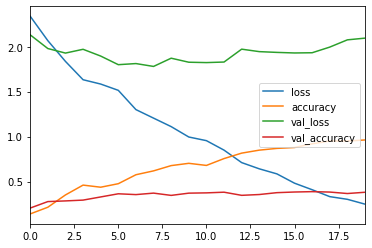

In [110]:
pd.DataFrame(history.history).plot()
plt.show()

## Train Autoencoder

In [34]:
X_train.shape

(50000, 32, 32, 3)

(None, 4, 4, 64)

(None, 32, 32, 3)

Train on 50000 samples, validate on 10000 samples
50000/50000 [==============================] - 57s 1ms/sample - loss: 0.5930 - mse: 0.0167 - val_loss: 0.5857 - val_mse: 0.0145


## Apply transfer learning

In [89]:
transfer_model = keras.models.clone_model(encoder)

In [96]:
transfer_model.add(keras.layers.Flatten())
transfer_model.add(keras.layers.Dense(100, activation='selu'))
transfer_model.add(keras.layers.Dense(10, activation='softmax'))

Freeze pre-trained conv layers for initial training

In [97]:
transfer_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)             

In [98]:
for l in transfer_model.layers:
    if 'conv2d' in l.name:
        l.trainable = False

In [99]:
transfer_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)             

In [91]:
l = transfer_model.layers[0]

In [100]:
transfer_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [101]:
transfer_history = transfer_model.fit(X_train_small, y_train_small, batch_size=32, epochs=1, validation_data=(X_test, y_test))

Train on 512 samples, validate on 10000 samples
512/512 [==============================] - 3s 6ms/sample - loss: 2.3105 - accuracy: 0.0879 - val_loss: 2.3286 - val_accuracy: 0.1020


Unfreeze the last convolutional layer

In [104]:
transfer_model.layers[4].trainable = True
transfer_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [107]:
transfer_history_2 = transfer_model.fit(X_train_small, y_train_small, batch_size=32, epochs=1, validation_data=(X_test, y_test))

Train on 512 samples, validate on 10000 samples
512/512 [==============================] - 3s 6ms/sample - loss: 2.2764 - accuracy: 0.1211 - val_loss: 2.2489 - val_accuracy: 0.1333


In [108]:
transfer_model.layers[2].trainable = True
transfer_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [109]:
transfer_history_3 = transfer_model.fit(X_train_small, y_train_small, batch_size=32, epochs=1, validation_data=(X_test, y_test))

Train on 512 samples, validate on 10000 samples
512/512 [==============================] - 3s 7ms/sample - loss: 2.3304 - accuracy: 0.1035 - val_loss: 2.2983 - val_accuracy: 0.1051


In [110]:
transfer_model.layers[0].trainable = True
transfer_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [111]:
transfer_history_4 = transfer_model.fit(X_train_small, y_train_small, batch_size=32, epochs=1, validation_data=(X_test, y_test))

Train on 512 samples, validate on 10000 samples
512/512 [==============================] - 3s 7ms/sample - loss: 2.2859 - accuracy: 0.1465 - val_loss: 2.2953 - val_accuracy: 0.1190


## Exercise 17


Train a DCGAN to tackle the image dataset of your choice, and use it to generate images. Add experience replay and see if this helps. Turn it into a conditional GAN where you can control the generated class.

Here are the main guidelines they proposed for building stable convolutional GANs:
* Replace any pooling layers with strided convolutions (in the discriminator) and transposed convolutions (in the generator).
* Use Batch Normalization in both the generator and the discriminator, except in the generator’s output layer and the discriminator’s input layer.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in the generator for all layers except the output layer, which should use tanh.
* Use leaky ReLU activation in the discriminator for all layers.

It is also useful to add label noise for the discriminator and dropout. As training of a GAN is stochastic, it can get stuck in all sorts of ways. Adding stochasticity to training helps.
Also, one should take care to use a kernel size that is divisible by the stride, otherwise one often sees checkerboard artifacts due to unequal coverage of the pixel space in the generator. This means that in GANs, it is common to see even kernel sizes.

### Dependencies

In [4]:
from tensorflow import keras
import numpy as np

In [1]:
# load custom functions
%run ./exercises_ch17.py

## Get CIFAR 10 data

In [39]:
(X_train, y_train), (X_test, y_test) = get_cifar10_data()

In [3]:
X_train.shape

(50000, 32, 32, 3)

1. A _generator_ that takes input of shape `(latent_dim,)` and produces output with shape `(32,32,3)` and values in [-1,1]
2. A _discriminator that takes input of shape `(32,32,3)` and produces a binary score in [0,1], the probability that the input is real.
3. A _GAN_ network that chains the discriminator and the generator, i.e. GAN(x) = discriminator(generator(x))
4. The training loop: Part 1 holds the generator fixed and improves the discriminator based on 50/50 real and fake data. Part 2 holds the discriminator fixed and improves the generator based on a purely fake sample. 

In [5]:
latent_dim = 32
image_dim = X_train.shape[1:]

In [16]:
generator = keras.models.Sequential([
    keras.layers.Dense(16*16*128, input_shape=(latent_dim,)),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Reshape((16,16,128)),
    keras.layers.Conv2D(256, kernel_size=5, strides=1, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv2D(256, 5, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv2D(256, 5, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv2D(3, 7, padding='same', activation='tanh')
])

In [17]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
batch_normalization_9 (Batch (None, 32768)             131072    
_________________________________________________________________
re_lu_5 (ReLU)               (None, 32768)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 256)       1024      
_________________________________________________________________
re_lu_6 (ReLU)               (None, 16, 16, 256)      

In [15]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(128, 3, input_shape=image_dim),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2D(128, kernel_size=4, strides=2),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2D(128, kernel_size=4, strides=2),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2D(128, kernel_size=4, strides=2),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 2, 2, 128)        

In [18]:
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)

In [19]:
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

### GAN

In [20]:
discriminator.trainable = False

In [21]:
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

In [22]:
gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)

In [23]:
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

### Train GAN

In [40]:
X_train = X_train * 2. - 1.
X_test = X_test * 2. - 1.

In [41]:
import tensorflow as tf

In [42]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [43]:
epochs = 10

In [ ]:
for epoch in range(epochs):
    print('Starting Epoch: {}'.format(epoch), end=' ')
    for X_batch in dataset:
        print('*', end='')
        # phase 1 - training the discriminator
        latent_vectors = tf.random.normal(shape=[batch_size, latent_dim])
        generated_images = generator(latent_vectors)
        X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        y1 += 0.05 * tf.random.uniform(tf.shape(y1))
        discriminator.trainable = True
        discriminator.train_on_batch(X_fake_and_real, y1)
        # phase 2 - training the generator
        noise = tf.random.normal(shape=[batch_size, latent_dim])
        y2 = tf.constant([[1.]] * batch_size)
        discriminator.trainable = False
        gan.train_on_batch(noise, y2)
    print('')

Starting Epoch: 0 **********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [ ]:
batch_size = 32
epochs = 10